In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.4.1


In [14]:
# 08时数据
lv1_08 = pd.read_csv(r'I:\Data\Personal Data\graduation project\Code\Machine Learning\basicdata\2007_lv1_08.csv',index_col='Unnamed: 0')
Temperature_08 = pd.read_csv(r'I:\Data\Personal Data\graduation project\Code\Machine Learning\basicdata\2007_Temperature_08.csv',index_col='Unnamed: 0')
merge_dataset =pd.merge(lv1_08,Temperature_08,on=lv1_08.index)
merge_dataset.drop('key_0',axis=1,inplace=True)
print(merge_dataset.shape)

# # 20时数据
# lv1_08 = pd.read_csv(r'I:\Data\Personal Data\graduation project\Code\Machine Learning\basicdata\2007_lv1_20.csv',index_col='Unnamed: 0')
# Temperature_08 = pd.read_csv(r'I:\Data\Personal Data\graduation project\Code\Machine Learning\basicdata\2007_Temperature_20.csv',index_col='Unnamed: 0')
# merge_dataset1 =pd.merge(lv1_08,Temperature_08,on=lv1_08.index)
# merge_dataset1.drop('key_0',axis=1,inplace=True)
# print(merge_dataset1.shape)
# # 连接
# merge_dataset = merge_dataset.append(merge_dataset1)

# 将'Rain'列转换为离散数值
merge_dataset['Rain'] = pd.Categorical(merge_dataset['Rain'])
merge_dataset['Rain'] = merge_dataset.Rain.cat.codes

# 去除空数据
merge_dataset[merge_dataset<-1000] = np.nan
merge_dataset.dropna(inplace=True)

# 去除['10','Azim', 'Elev']几列
# 温度训练
merge_dataset.drop(['10','Rain', 'TkBB(K)','Rh(%)', 'Pres(mb)', 'Tir(K)', 'Azim', 'Elev',' 22.235', ' 23.035', ' 23.835', ' 26.235', ' 30.000'],axis=1,inplace=True)

(365, 68)


In [15]:
merge_dataset = merge_dataset.round(1)

In [16]:
# input:18
# output:47
merge_dataset.columns

Index(['Tamb(K)', ' 51.250', ' 52.280', ' 53.850', ' 54.940', ' 56.660',
       ' 57.290', ' 58.800', '0.00', '0.10', '0.20', '0.30', '0.40', '0.50',
       '0.60', '0.70', '0.80', '0.90', '1.00', '1.25', '1.50', '1.75', '2.00',
       '2.25', '2.50', '2.75', '3.00', '3.25', '3.50', '3.75', '4.00', '4.25',
       '4.50', '4.75', '5.00', '5.25', '5.50', '5.75', '6.00', '6.25', '6.50',
       '6.75', '7.00', '7.25', '7.50', '7.75', '8.00', '8.25', '8.50', '8.75',
       '9.00', '9.25', '9.50', '9.75', '10.00'],
      dtype='object')

In [17]:
# 归一化
def norm(x):
  return (x - merge_dataset.describe().transpose()['mean']) / merge_dataset.describe().transpose()['std']

# merge_dataset.iloc[:,:8] = norm(merge_dataset).iloc[:,:8]

In [18]:
# 乱序，分离训练数据与测试数据
train_data = merge_dataset.sample(frac=0.8,random_state=0)
test_data = merge_dataset.drop(train_data.index)
# 分离标签
train_labels = train_data.iloc[:,8:]
test_labels = test_data.iloc[:,8:]
train_data.drop(train_labels.columns,axis=1,inplace=True)
test_data.drop(train_labels.columns,axis=1,inplace=True)

print(train_data.shape,test_data.shape,train_labels.shape,test_labels.shape)

(128, 8) (32, 8) (128, 47) (32, 47)


In [19]:
def build_model():
  model = keras.Sequential([
    layers.Dense(len(train_data.keys()), activation='relu', input_shape=[len(train_data.keys())]),
    layers.Dense(23, activation='relu'),
    layers.Dense(47)
  ])

  opt = tf.keras.optimizers.RMSprop(0.001)
  # tf.train.GradientDescentOptimizer(0.001)
  # tf.keras.optimizers.RMSprop(0.001)
  # tf.optimizers.Adam(1e-3)

  model.compile(loss='mse', #损失函数
                optimizer=opt, # 优化器
                metrics=['mae', 'mse'] # 性能评估指标
                )
  return model

In [20]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 23)                207       
_________________________________________________________________
dense_5 (Dense)              (None, 47)                1128      
Total params: 1,407
Trainable params: 1,407
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(train_data,
                    train_labels,
                    batch_size=32,
                    epochs=500, 
                    verbose=2,
                    validation_split = 0.2)

Epoch 1/500
4/4 - 6s - loss: 58424.2930 - mae: 232.5465 - mse: 58424.2930 - val_loss: 55495.5352 - val_mae: 227.3242 - val_mse: 55495.5352
Epoch 2/500
4/4 - 1s - loss: 55214.6875 - mae: 226.6335 - mse: 55214.6875 - val_loss: 53235.5898 - val_mae: 222.5672 - val_mse: 53235.5898
Epoch 3/500
4/4 - 0s - loss: 52986.3984 - mae: 221.8198 - mse: 52986.3984 - val_loss: 51178.1836 - val_mae: 217.7316 - val_mse: 51178.1836
Epoch 4/500
4/4 - 1s - loss: 50931.9219 - mae: 216.8954 - mse: 50931.9219 - val_loss: 49179.9805 - val_mae: 212.6576 - val_mse: 49179.9805
Epoch 5/500
4/4 - 0s - loss: 48894.9375 - mae: 211.6683 - mse: 48894.9375 - val_loss: 47099.1094 - val_mae: 207.1100 - val_mse: 47099.1094
Epoch 6/500
4/4 - 0s - loss: 46751.6172 - mae: 205.9154 - mse: 46751.6172 - val_loss: 44907.7227 - val_mae: 201.0558 - val_mse: 44907.7227
Epoch 7/500
4/4 - 0s - loss: 44510.3477 - mae: 199.6796 - mse: 44510.3477 - val_loss: 42628.1250 - val_mae: 194.5445 - val_mse: 42628.1250
Epoch 8/500
4/4 - 0s - loss

In [22]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
495,30.306530,4.458224,30.306530,22.020897,3.518706,22.020897,495
496,21.298470,3.659936,21.298470,59.076462,6.622912,59.076462,496
497,26.872280,4.086246,26.872280,31.025923,4.057293,31.025923,497
498,29.567295,4.307341,29.567295,29.671202,4.024557,29.671202,498
499,27.965689,4.170919,27.965689,24.225288,3.593511,24.225288,499


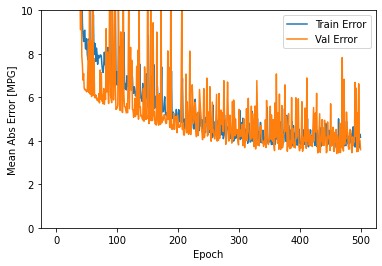

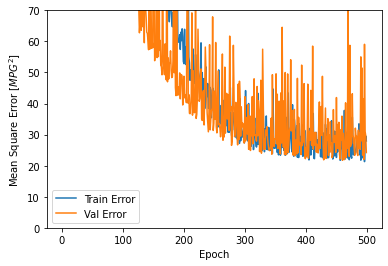

In [23]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,10])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,70])
  plt.legend()
  plt.show()


plot_history(history)

In [24]:
loss, mae, mse = model.evaluate(test_data, test_labels, verbose=1)

print("Testing set Mean Abs Error: {:5.2f} MAE".format(mae))

1/1 [==============================] - 1s 656ms/step - loss: 20.0748 - mae: 3.3308 - mse: 20.0748
Testing set Mean Abs Error:  3.33 MAE


MAE: 3.33
数据量： 2007年08时
是否保留一位小数：是
是否归一化：否
batch_size = 32
epochs = 500